# Introduction

In this notebook, wiggling error (cyclic error) of phase that can be obtained with indirect ToF (iToF) is simulated.  
- General usage of cyclic error simulator.
- Examples from academic papers.

# Run Simulation

## General Simulation

Some simulation parameters can be set in CONFIG. 

In [1]:
config = {
    "num_components": 4,  # Number of components
    "phase_shift": [0, 90, 180, 270],  # in degree
    "modulation_frequency": 20e6,  # Hz
    "duty_cycle": 0.5,  # Duty cycle between 0 and 1
    "num_time_samples": 3000,  # Number of samples in time domain.
    "figure": {  # Figure config
        "show_signals": True,
        "show_spectra": True,
        "show_phase_signals_and_cyclic_error": True
    }
}

In [2]:
from functions.signal import *
from functions.visualization import *

phase_simulator = PhaseSimulator(config)
simulation_data = phase_simulator()
data_visualizer = DataVisualizer(config["figure"], simulation_data)

/Users/kotarosonoda/opt/anaconda3/envs/data_analysis_py39/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


First, sensor demodulation signal, source modulation signal (illumination signal), and their correlation signal are visualized. 

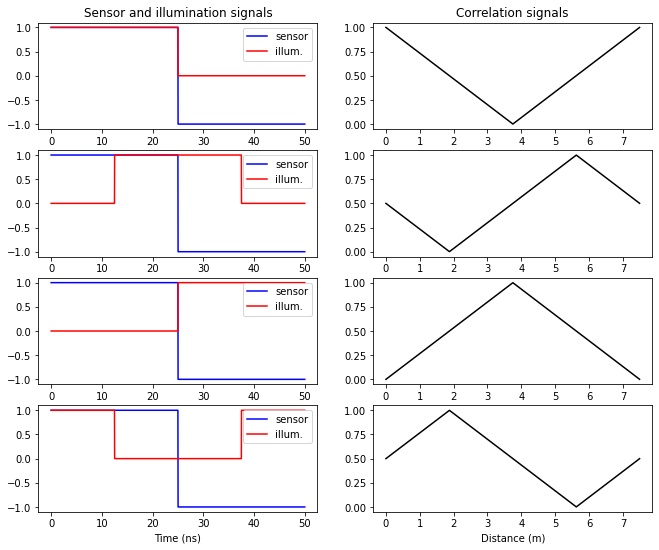

In [3]:
data_visualizer.show_signals(simulation_data)

Secondly, FT spectra of the aforementioned signals are visualized.

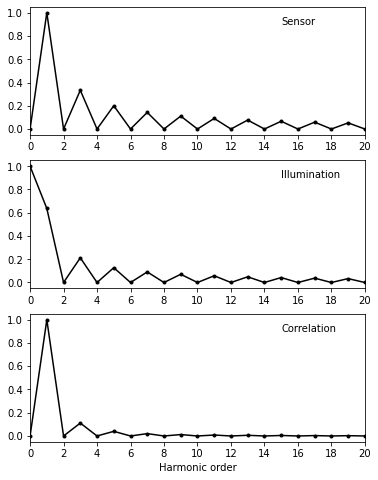

In [4]:
data_visualizer.show_spectra(simulation_data)

At last, simulated phase is compared with ground-truth (GT) phase to evaluate phase error. You can see cyclic error.

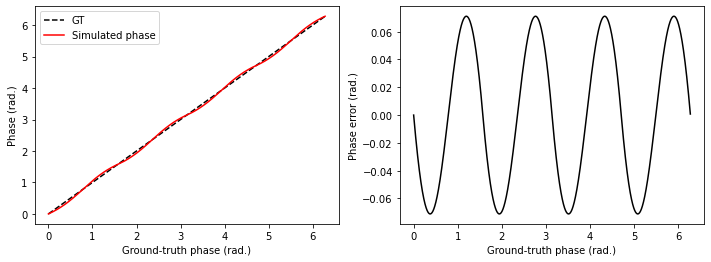

In [5]:
data_visualizer.show_phase_signals_and_cyclic_error(simulation_data)

## Example 1: Duty Cycle Dependence

In Fig.1 of [[1](https://ieeexplore.ieee.org/document/7391811)], duty cycle is sweeped to see how duty cycle affects to root mean square error of phase. This type of data is useful to determin optimal duty cycle. With the current simulation tool, we can reproduce their results. 

In [6]:
duty_cycle = np.arange(0.05, 0.505, 0.005)  # 0.05 to 0.5

phase_shift_list = [
    [0, 120, 240],
    [0, 90, 180, 270],
    [0, 72, 144, 216, 288]
]

rmse_phase = {}

for phase_shift in phase_shift_list:

    rms = []
    for dc in duty_cycle:
        test_config = {
            "phase_shift": phase_shift,
            "modulation_frequency": 20e6,  # Hz
            "duty_cycle": dc,  # Duty cycle between 0 and 1
            "num_time_samples": 3000,  # Number of samples in time domain.
            "num_components": len(phase_shift)
        }
        
        phase_simulator = PhaseSimulator(test_config)
        simulation_data = phase_simulator()
        rms.append(simulation_data.rms_phase_error)
    rms = np.array(rms)
    rmse_phase[f"rmse_{len(phase_shift)}components"] = rms

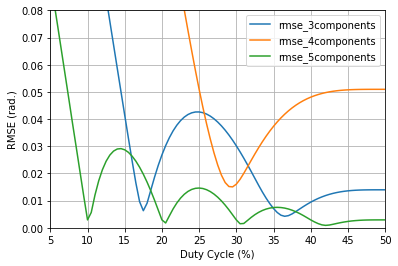

In [8]:
import matplotlib.pyplot as plt

for rmse_key in list(rmse_phase.keys()):
    plt.plot(duty_cycle*100, rmse_phase[rmse_key], label=rmse_key)
plt.xlim([5, 50])
plt.ylim([0, 0.08])
plt.xlabel("Duty Cycle (%)")
plt.ylabel("RMSE (rad.)")
plt.legend()
plt.grid()

As you can see, there are some optimal setting for the duty cycle in order to achieve the minimum RMSE of phase.

## Example 2: Cyclic Error Cancelation Method

In the Section 3.1 of [[2](https://www.mdpi.com/2304-6732/10/2/170)], a method for reducing cyclic error is proposed. In this method, two measurements are conducted by shifting the source modulation signal by π/4 radian. This method can be tested with the presented simulator. 

In [9]:
duty_cycle = np.arange(0.05, 0.505, 0.005)  # 0.05 to 0.5

illum_sig_offsets = [45, 0]  # in degree

simulated_phases = []
for illum_sig_offset in illum_sig_offsets:
    test_config = {
        "phase_shift": [0, 90, 180, 270],
        "modulation_frequency": 20e6,  # Hz
        "duty_cycle": 0.5,  # Duty cycle between 0 and 1
        "num_time_samples": 3000,  # Number of samples in time domain.
        "source_modulation_signal_phase_offset": illum_sig_offset,
        "num_components":4
    }
        
    phase_simulator = PhaseSimulator(test_config)
    simulation_data = phase_simulator()
    simulated_phases.append(simulation_data.simulated_phase.tolist())
simulated_phases = np.array(simulated_phases)

RMSE (reference): 0.05094678678791319 rad.
RMSE (Improved method): 0.0021797675058057445 rad.
RMSE is reduced by a factor of 23.37257833792731 radian.


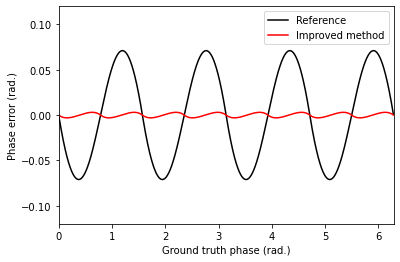

In [11]:
new_phase = 0.5 * (simulated_phases[0,:] + simulated_phases[1,:] - 0.25 * np.pi)
corrected_cyclic_error = new_phase-simulation_data.gt_phase
corrected_cyclic_error -= np.mean(corrected_cyclic_error)

rsme1 = np.sqrt(np.mean(simulation_data.cyclic_error**2))
rsme2 = np.sqrt(np.mean(corrected_cyclic_error**2))
print(f"RMSE (reference): {rsme1} rad.")
print(f"RMSE (Improved method): {rsme2} rad.")
print(f"RMSE is reduced by a factor of {rsme1/rsme2} radian.")

plt.figure()
plt.plot(simulation_data.gt_phase, simulation_data.cyclic_error, "k-", label="Reference")
plt.plot(simulation_data.gt_phase, corrected_cyclic_error, "r-", label="Improved method")
plt.legend()
plt.xlim([0, 2*np.pi])
plt.ylim([-0.12, 0.12])
plt.xlabel("Ground truth phase (rad.)")
plt.ylabel("Phase error (rad.)")
plt.show()

As you can see, the improved method can significantly reduce the cyclic error.

# Reference
[[1](https://ieeexplore.ieee.org/document/7391811)] V. N. Xuan, W. Weihs, and O. Loffeld, Illumination, phase step optimization and improvements in simultaneous multiple frequency measurement for Time-of-Flight sensors, 2015 International Conference on 3D imaging (IC3D), Liege, Belgium, pp. 1-6, 2015   
[[2](https://www.mdpi.com/2304-6732/10/2/170)] Z. Zheng, P. Song, X. Wang, W. Zhang, and Y. Bai, Wiggling-Related Error Correction Method for Indirect ToF Imaging Systems, Photonics, 10(2), 170, 2023